In [2]:
import os
import sys
import glob
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
warnings.filterwarnings('ignore')
pplt.rc.update({'reso':'xx-hi','figure.dpi':100})

In [3]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']    
MODELSDIR  = CONFIGS['filepaths']['models']
WEIGHTSDIR = CONFIGS['filepaths']['weights']
MODELS     = CONFIGS['models']
SPLIT      = 'valid'   

In [22]:
with xr.open_dataset(f'{SPLITSDIR}/{SPLIT}.h5',engine='h5netcdf') as ds:
    dlev = ds['dlev'].load()
    lev  = ds['lev'].load()

results = {}
for model in MODELS:
    name        = model['name']
    description = model['description']
    filepath    = os.path.join(WEIGHTSDIR,f'{name}_{SPLIT}_weights.nc')
    if 'kernel' in name:
        with xr.open_dataset(filepath,engine='h5netcdf') as ds:
            weights = ds['weights'].load()
        kernel = weights*dlev
        means  = kernel.mean(dim='member') if 'member' in kernel.dims else kernel
        stds   = kernel.std(dim='member') if 'member' in kernel.dims else None
        results[name] = dict(description=description,means=means,stds=stds)

print(f'Found {len(results)} completed kernel models for `{SPLIT}`')

nrows = 4
ncols = 3

Found 4 completed kernel models for `valid`


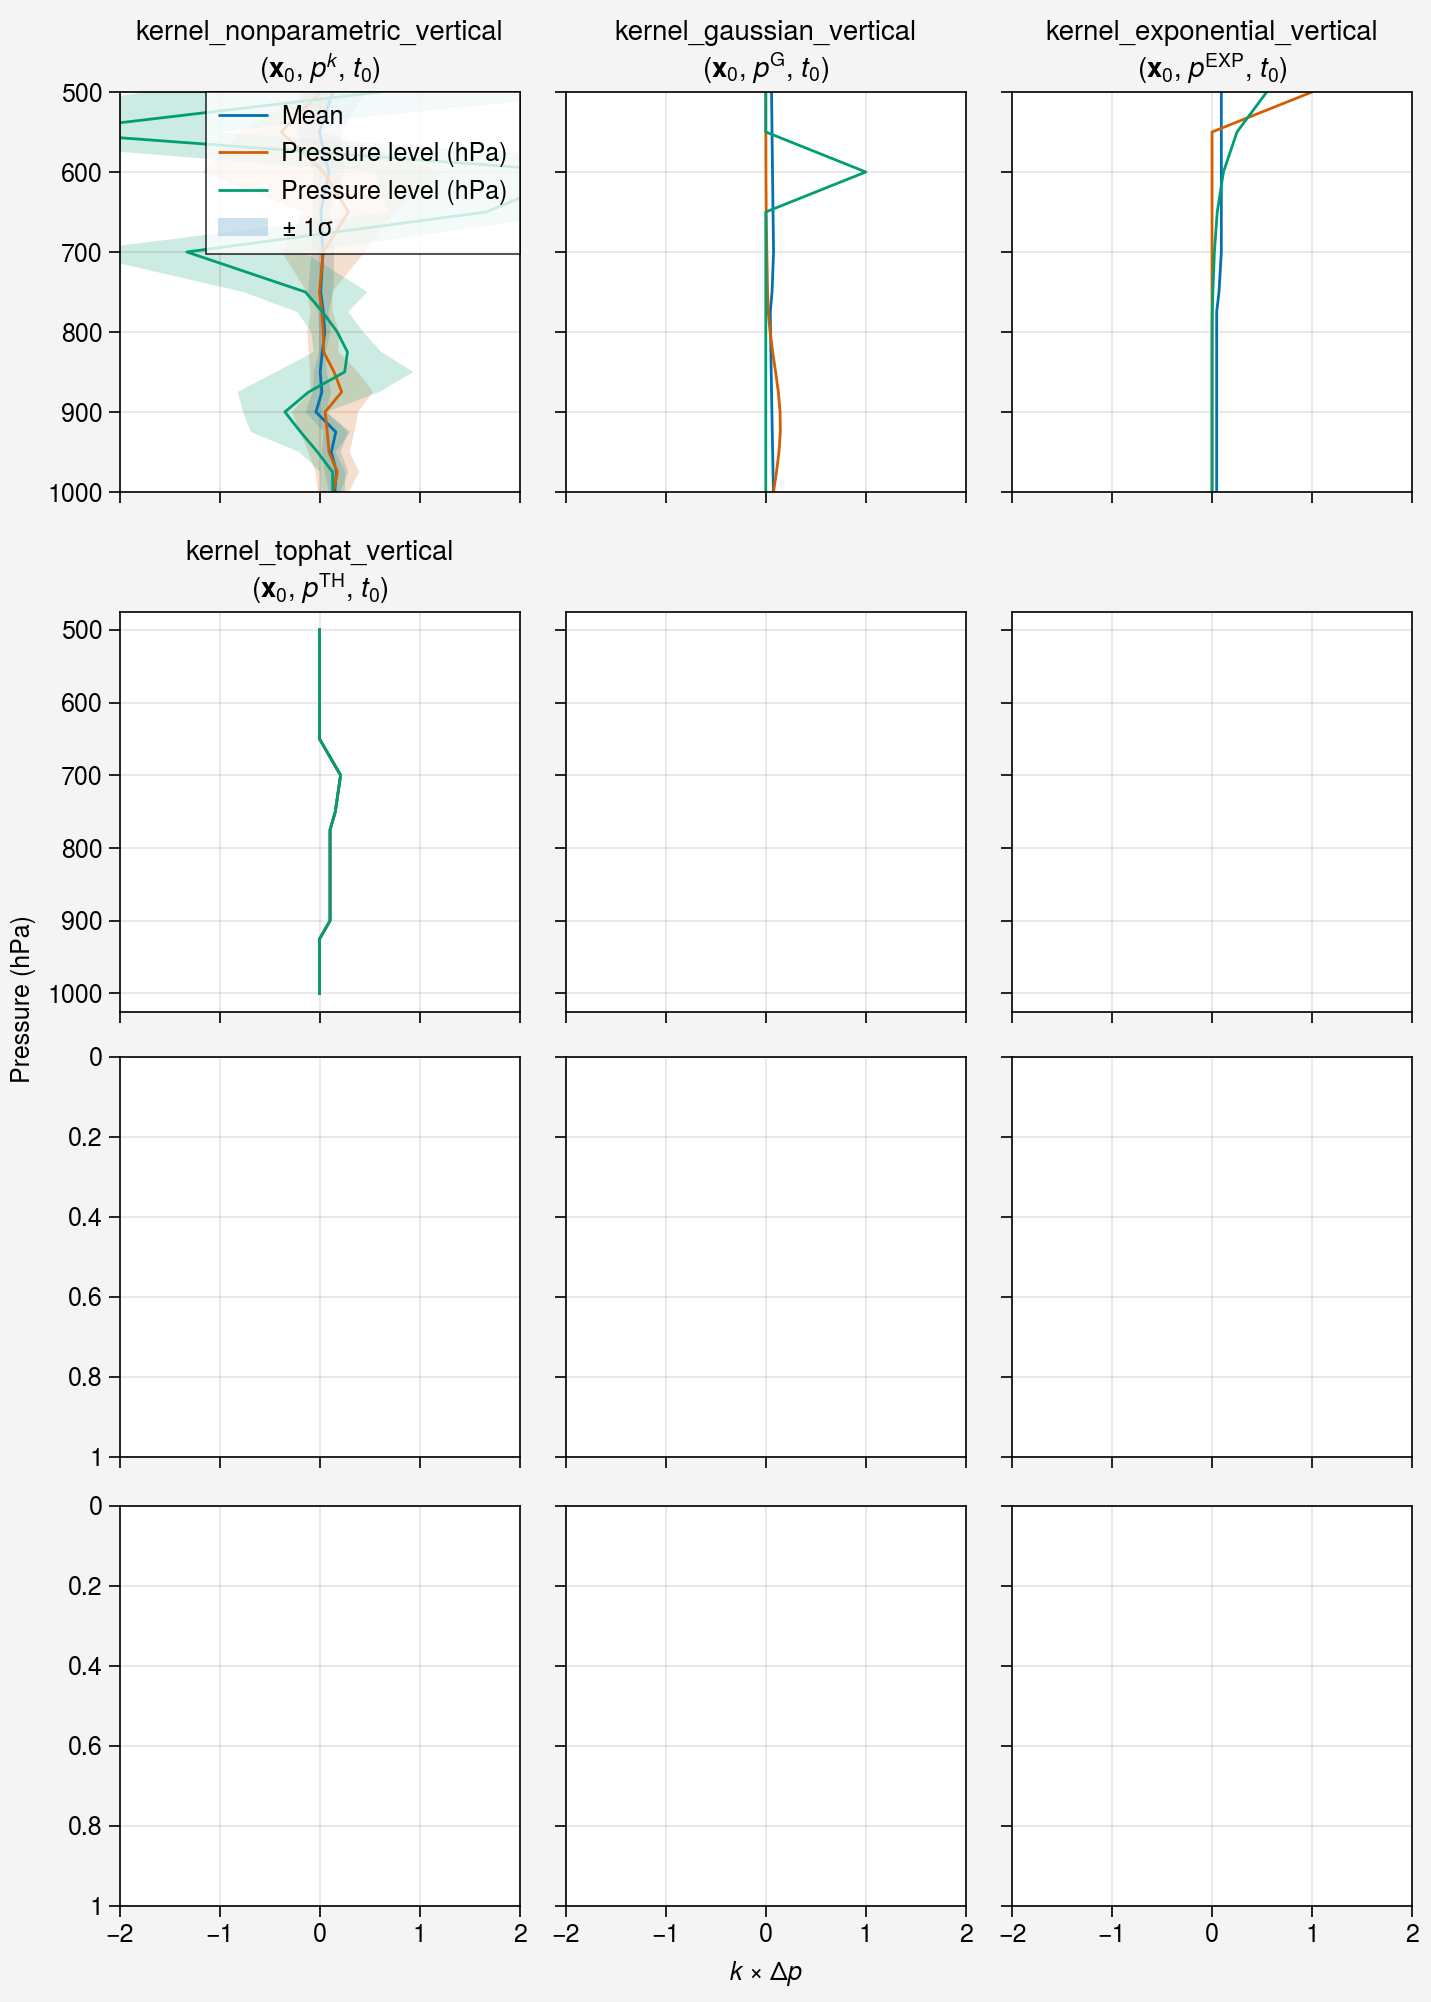

In [26]:
labels = [r'RH',r'$\mathit{\theta_e}$',r'$\mathit{\theta_e}*$']

fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=2,refheight=2,share=True)


names = list(results.keys())
for k, name in enumerate(names[:nrows * ncols]):
    ax = axs[k]
    means = results[name]['means']
    stds  = results[name]['stds']

    # pick the field dim name (usually 'field'); fall back to first non-lev dim
    field_dim = 'field' if 'field' in means.dims else next(d for d in means.dims if d != 'lev')

    for i in range(means.sizes[field_dim]):
        mean = means.isel({field_dim: i})
        ax.plot(mean, lev, linewidth=1, label='Mean' if i == 0 else None)

        if stds is not None:
            std = stds.isel({field_dim: i})
            ax.fill_betweenx(
                lev, mean - std, mean + std,
                alpha=0.2, label=r'± 1$\sigma$' if (i == 0) else None
            )

    ax.format(title=f'{name}\n{results[name]["description"]}')

axs[0].legend(loc='ur',ncols=1)
axs.format(xlabel='$\mathit{k}$ × $\Delta\mathit{p}$',xlim=(-2,2),xticks=1,xminorticks='none',xreverse=False,
           ylabel='Pressure (hPa)',yminorticks='none',yreverse=True)

pplt.show()

Picked models: {'nonparametric': 'kernel_nonparametric_vertical', 'gaussian': 'kernel_gaussian_vertical', 'exponential': 'kernel_exponential_vertical', 'tophat': 'kernel_tophat_vertical'}


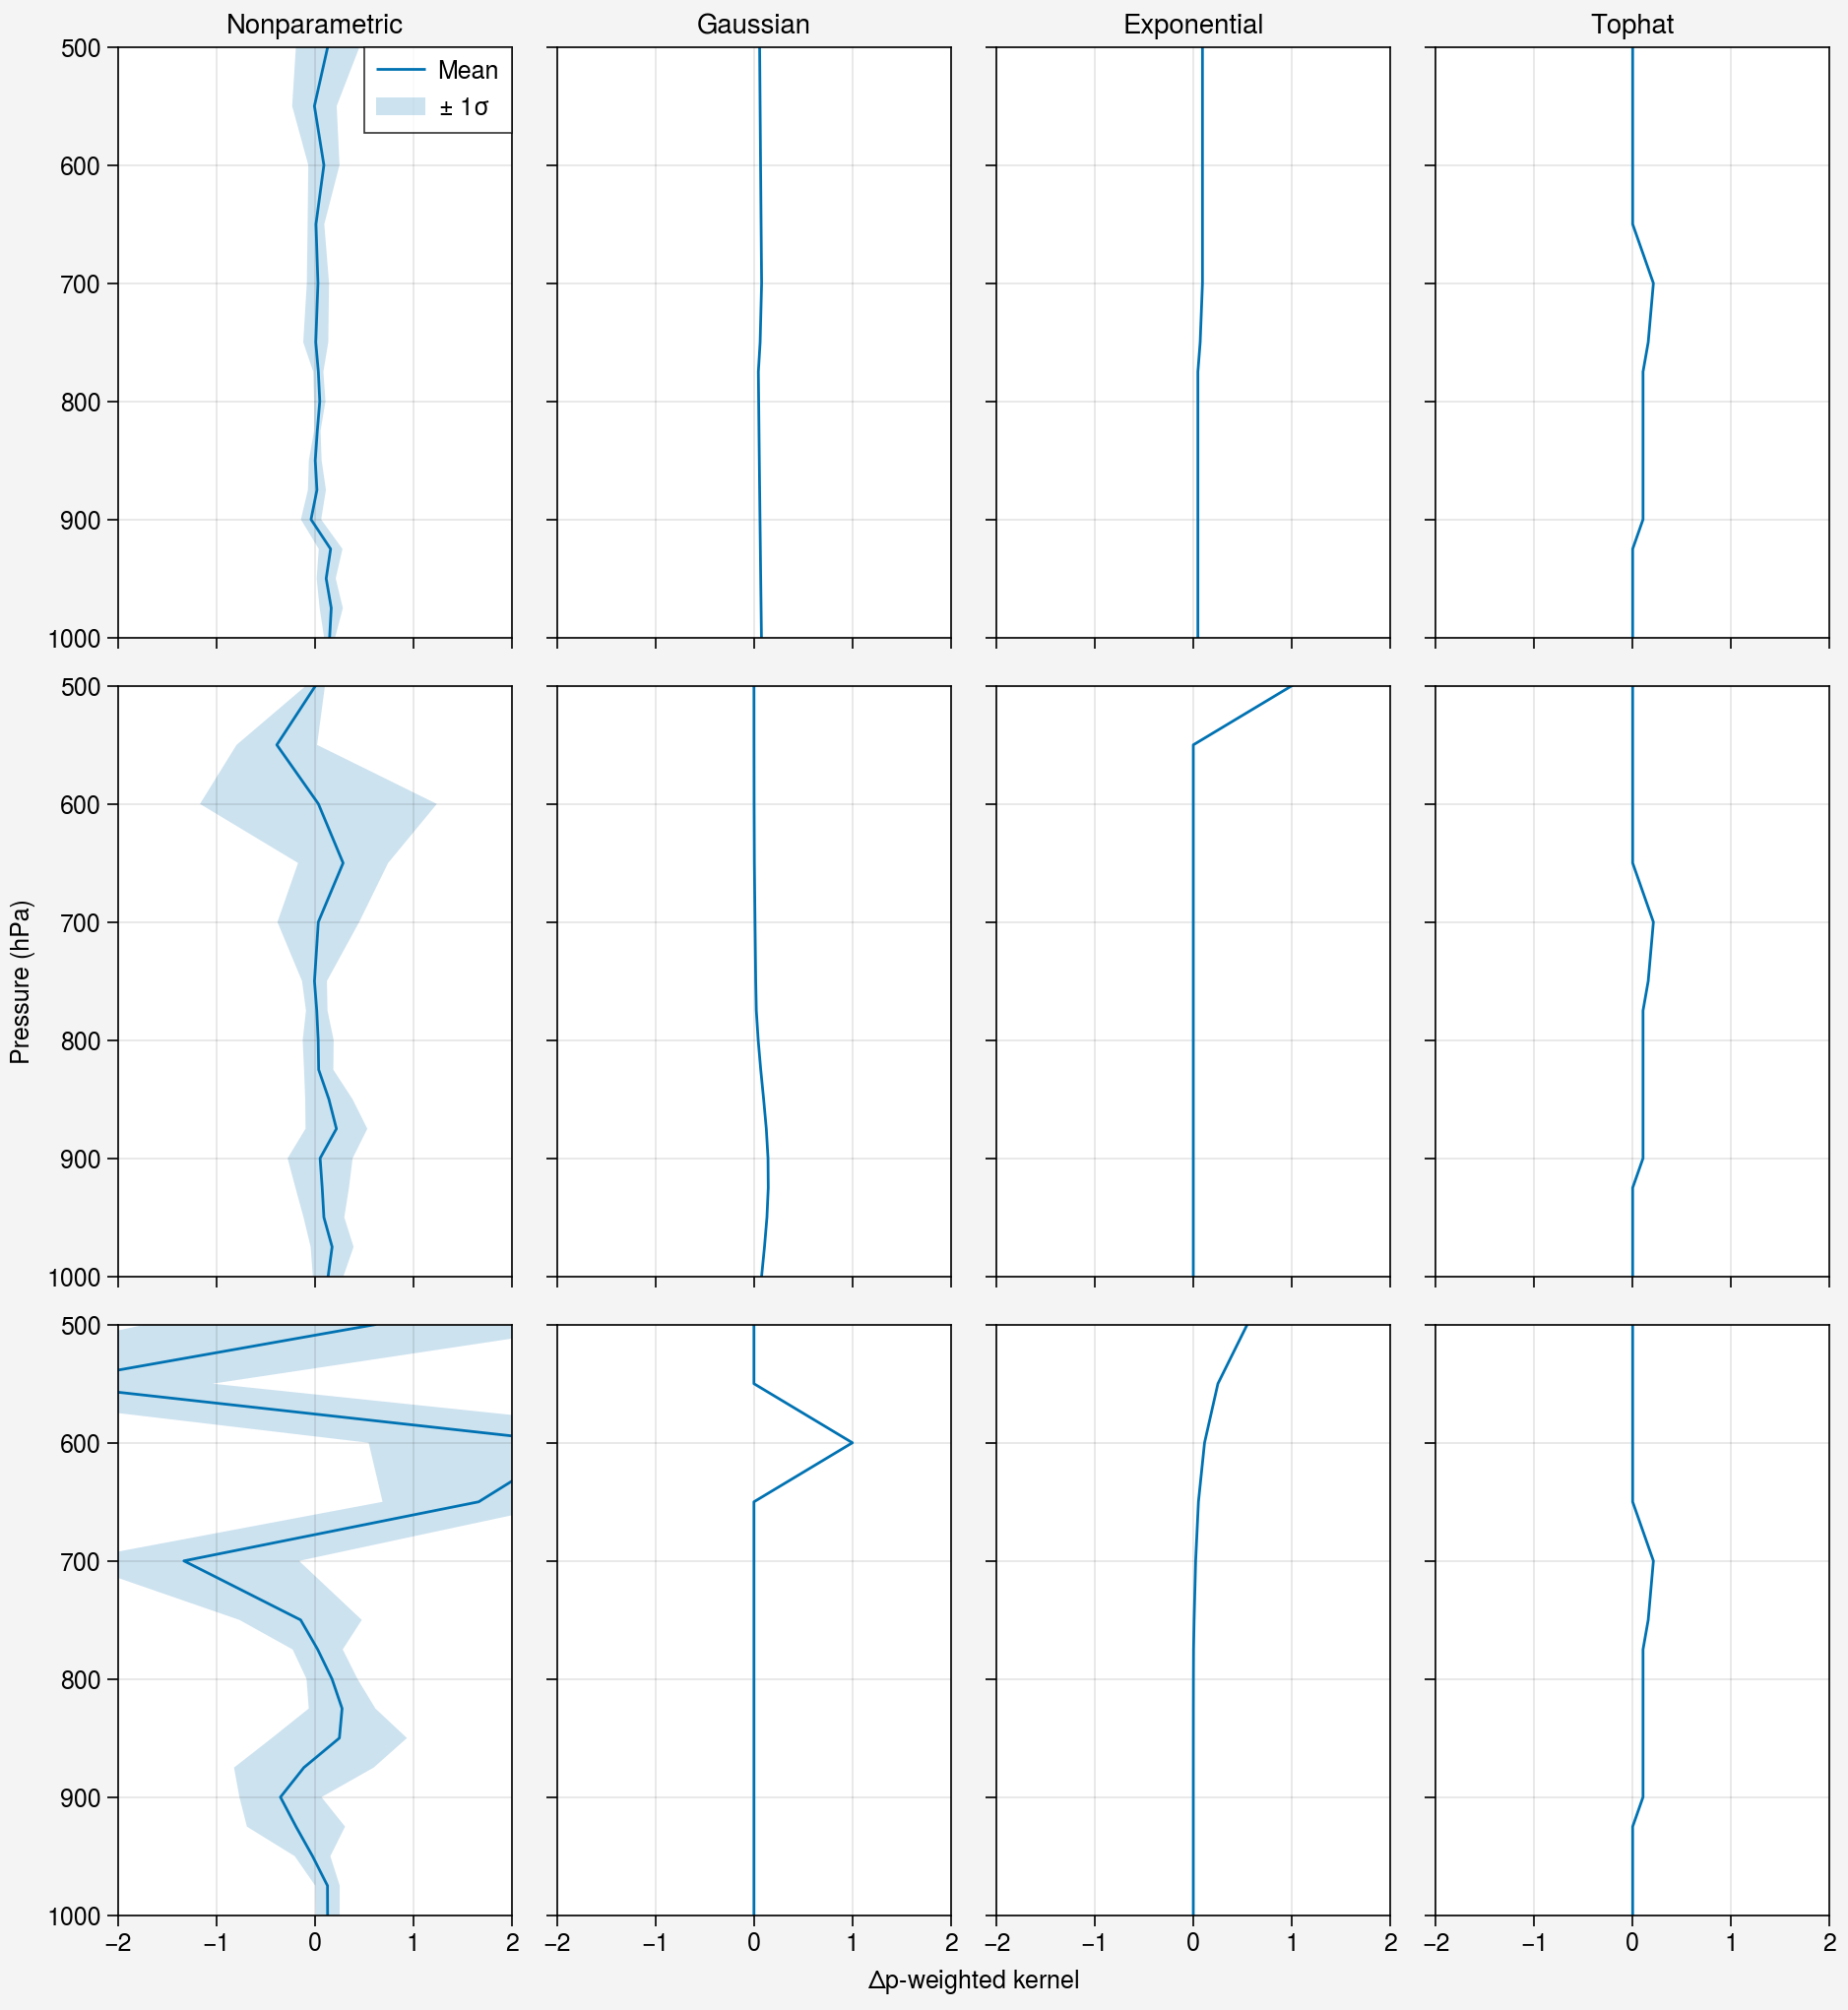

In [28]:
colorder = [
    ('nonparametric','Nonparametric'),
    ('gaussian','Gaussian'),
    ('exponential','Exponential'),
    ('tophat','Top-Hat')]

def pick_model(family):
    for name in results:
        if family in name:
            return name
    return None

picked = {family: pick_model(fam) for fam, _ in col_order}
print("Picked models:", picked)

# Infer field dimension and count
any_name = next(iter(results))
means0 = results[any_name]['means']
field_dim = 'field' if 'field' in means0.dims else next(d for d in means0.dims if d != 'lev')
nrows = means0.sizes[field_dim]
ncols = len(col_order)

row_titles = labels if len(labels) == nrows else [str(v) for v in means0[field_dim].values]

fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=2,refheight=3,share=True)
axs.format(
    xlabel=r'$\Delta p$-weighted kernel',
    xlim=(-2, 2),
    xticks=1,
    xminorticks='none',
    ylabel='Pressure (hPa)',
    yminorticks='none',
    yreverse=True)


# for i,(family,title) in enumerate(colorder):
#     name = picked[fam]
#     if name is None:
#         for j in range(nrows):
#             axs[i,j].format(title=title if j== 0 else None)
#         continue

#     means = results[name]['means']
#     stds  = results[name]['stds']

#     # Align with lev
#     means, _ = xr.align(means, lev, join='inner')
#     if stds is not None:
#         stds, _ = xr.align(stds, lev, join='inner')

#     for r in range(nrows):
#         ax = axs[r, c]
#         mean = means.isel({field_dim: r})
#         ax.plot(mean, lev, linewidth=1, label='Mean' if (r == 0 and c == 0) else None)

#         if stds is not None:
#             std = stds.isel({field_dim: r})
#             ax.fill_betweenx(
#                 lev, mean - std, mean + std,
#                 alpha=0.2, label=r'± 1$\sigma$' if (r == 0 and c == 0) else None
#             )

#         # Column titles only on top row
#         if r == 0:
#             ax.format(title=fam_title)

#     # Row labels on the left
#     axs[c*0, 0]  # no-op, just for clarity

# Set row labels
for r in range(nrows):
    axs[r, 0].format(ylabel=row_titles[r])

axs[0, 0].legend(loc='ur', ncols=1)
)

pplt.show()


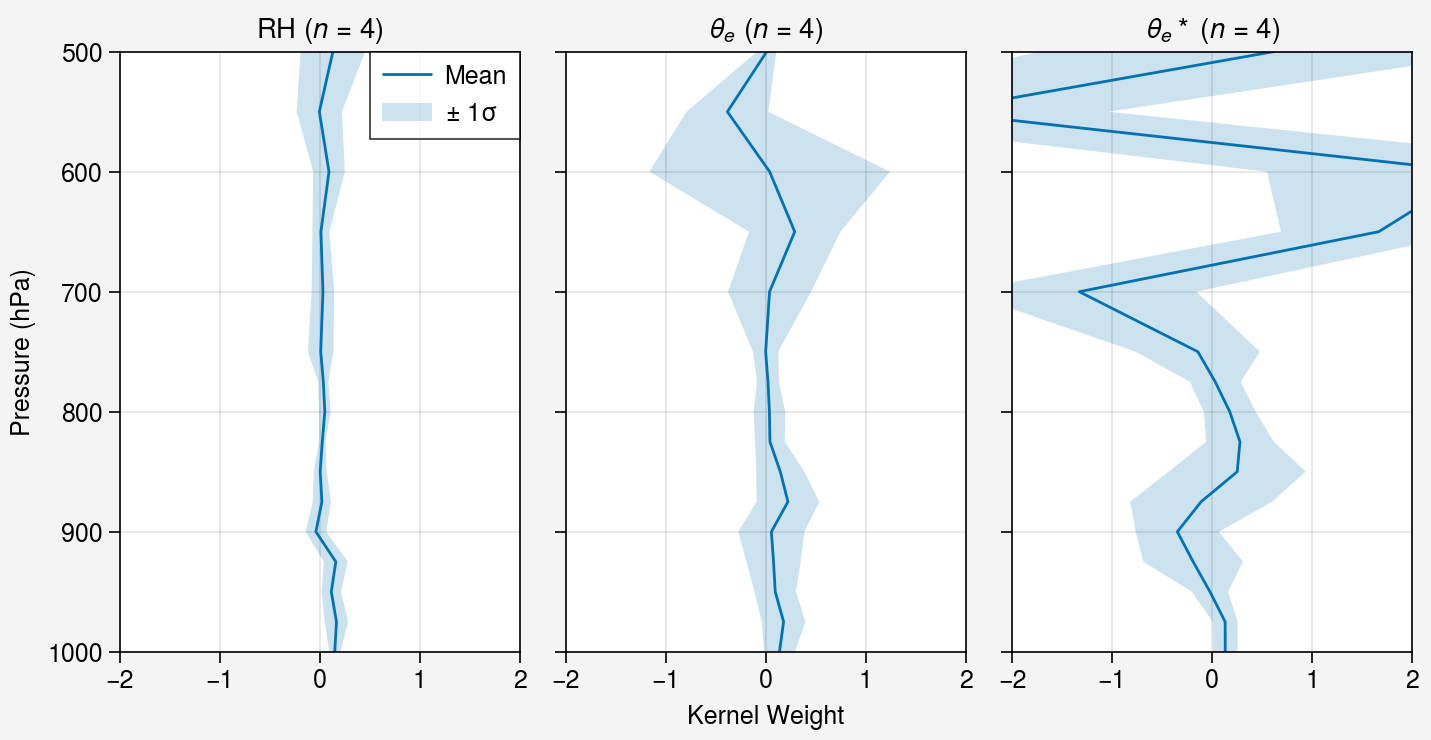

In [8]:
labels = [r'RH ($\mathit{n}$ = 4)',r'$\mathit{\theta_e}$ ($\mathit{n}$ = 4)',r'$\mathit{\theta_e}*$ ($\mathit{n}$ = 4)']     
means  = (weights*dlev).mean(dim='member')
stds   = (weights*dlev).std(dim='member')

fig,axs = pplt.subplots(nrows=1,ncols=3,refwidth=2,refheight=3,share=True)
for i,ax in enumerate(axs):
    mean = means[i,:]
    std  = stds[i,:]
    axs.format(xreverse=False)
    ax.plot(mean,levs,linewidth=1,label='Mean')
    ax.fill_betweenx(levs,mean-std,mean+std,alpha=0.2,label=r'± 1$\sigma$')
    ax.format(title=labels[i])
axs[0].legend(loc='ur',ncols=1)
axs.format(xlabel='Kernel Weight',xlim=(-2,2),xticks=1,xminorticks='none',xreverse=False,
           ylabel='Pressure (hPa)',yminorticks='none',yreverse=True)
pplt.show()